# Overview

Clustering is an unsupervised learning method whose task is to divide the population or data points into a number of groups, such that data points in a group are more similar to other data points in the same group and dissimilar to the data points in other groups. It is basically a collection of objects based on similarity and dissimilarity between them.

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. Given the fact that the dataset provided for Categorical Feature Encoding have 100% categorical variables, we are performing the kmeans clustering analysis by employing two different encoding techniques, viz, one hot encoding and similarity encoding of the image_name feature.

In this approach, we are using KMeans clustering technique, in order to group together image_repos which have a high probability of occuring together in the same cluster_id. In addition to this we will also be using telemetry information linked with the cluster_id.

# Data collection and pre-processing

In [1]:
import io
import boto3
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv, find_dotenv

In [2]:
%matplotlib inline
load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
# CEPH Bucket variables
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

# s3 resource to communicate with storage
s3 = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

# access the parquet file as an s3 object

obj1 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/date=2021-05-12/2021-05-12.parquet"
)
obj2 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/date=2021-05-12/2021-05-12.parquet"
)
obj3 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/dataframe_image_id.parquet"
)
obj4 = s3.Object("DH-PLAYPEN", "ccx/fingerprinting/containers/df_cont_image_id.parquet")
obj5 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/telemeter_image_data.parquet"
)
obj6 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/telemeter_cont_data.parquet"
)

obj7 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/df_image_layerid.parquet"
)
# download the file into the buffer
buffer1 = io.BytesIO()
obj1.download_fileobj(buffer1)
buffer2 = io.BytesIO()
obj2.download_fileobj(buffer2)
buffer3 = io.BytesIO()
obj3.download_fileobj(buffer3)
buffer4 = io.BytesIO()
obj4.download_fileobj(buffer4)
buffer5 = io.BytesIO()
obj5.download_fileobj(buffer5)
buffer6 = io.BytesIO()
obj6.download_fileobj(buffer6)
buffer7 = io.BytesIO()
obj7.download_fileobj(buffer7)

# read the buffer and create the dataframe
image_layers_df = pd.read_parquet(buffer1)
image_id_map = pd.read_parquet(buffer3)
image_layer_idmap = pd.read_parquet(buffer7)
containers_df = pd.read_parquet(buffer2)
cont_id_map = pd.read_parquet(buffer4)
telemeter_image_data = pd.read_parquet(buffer5)
telemeter_cont_data = pd.read_parquet(buffer6)

We now have the six sets of dataframes,

- Image layer dataset (_**image_layers_df**_)
- Image name mapping for sha's of image_id from image layer dataset (_**image_id_mapping**_)
- Image layer id mapping for sha's of the layers of the corresponding image_id (**image_layer_idmap**)
- Containers dataset (_**containers_df**_)
- Image name mapping for sha's of the image_id from container dataset (_**cont_imageid_map**_)
- Information from the telemeter for the corresponding cluster_id from image_layers_dataset (_**telemeter_image_data**_)
- Information from the telemeter for the corresponding cluster_id from container dataset (_**telemeter_cont_data**_)

**Image layer Dataset**

In [4]:
image_layers_df.head(2)

cluster_id  \
0  00003d61-9db1-4757-9cd1-84df271daeb9   
1  00003d61-9db1-4757-9cd1-84df271daeb9   

                                            image_id  \
0  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
1  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   

                                      layer_image_id  layer_image_level  \
0  sha256:9ebb302e1fb002fb643091710dac46f8258781d...                  0   
1  sha256:a74396a32e85c2feeedf76052ed3297859810c8...                  1   

  first_command     first_arg  \
0  icTsn2s_EIax  2v1NneeWoS_9   
1  icTsn2s_EIax  2v1NneeWoS_9   

                                        archive_path  
0  archives/compressed/00/00003d61-9db1-4757-9cd1...  
1  archives/compressed/00/00003d61-9db1-4757-9cd1...

**Pyxis data for the image SHA’s in image_id column of image_layers dataset**

In [5]:
image_id_map = image_id_map.reset_index()
image_id_map.head(2)

image_id License architecture  \
0  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...  GPLv2+       x86_64   
1  sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...  GPLv2+       x86_64   

                   build-date                       com.redhat.build-host  \
0  2021-04-30T00:31:42.349887  cpt-1004.osbs.prod.upshift.rdu2.redhat.com   
1  2021-04-30T00:22:29.539443  cpt-1008.osbs.prod.upshift.rdu2.redhat.com   

                 com.redhat.component           com.redhat.license_terms  \
0         ose-cli-artifacts-container  https://www.redhat.com/agreements   
1  openshift-enterprise-cli-container  https://www.redhat.com/agreements   

                                         description distribution-scope  \
0  OpenShift is a platform for developing, buildi...             public   
1  OpenShift is a platform for developing, buildi...             public   

                                  io.k8s.description io.k8s.display-name  \
0  OpenShift is a platform for developing, buildi...   OpenShift Clients   
1  OpenShift is a platform for developing, buildi...    OpenShift Client   

               io.openshift.build.commit.id  \
0  a765590e1b87b014b9d81f9ea534460d6dff73f2   
1  a765590e1b87b014b9d81f9ea534460d6dff73f2   

                       io.openshift.build.commit.url  \
0  https://github.com/openshift/oc/commit/a765590...   
1  https://github.com/openshift/oc/commit/a765590...   

  io.openshift.build.source-location io.openshift.expose-services  \
0    https://github.com/openshift/oc                                
1    https://github.com/openshift/oc                                

  io.openshift.maintainer.component io.openshift.maintainer.product  \
0                                oc    OpenShift Container Platform   
1                                oc    OpenShift Container Platform   

  io.openshift.tags     maintainer                         name  \
0     openshift,cli  Red Hat, Inc.  openshift/ose-cli-artifacts   
1     openshift,cli  Red Hat, Inc.            openshift/ose-cli   

           release                                            summary  \
0  202104292348.p0  Provides the latest release of Red Hat Univers...   
1  202104292348.p0  Provides the latest release of Red Hat Univers...   

                                                 url  \
0  https://access.redhat.com/containers/#/registr...   
1  https://access.redhat.com/containers/#/registr...   

                                    vcs-ref vcs-type         vendor version  \
0  43f412b2932a5ecfe5ebedcab38cf2915cf03813      git  Red Hat, Inc.  v4.8.0   
1  d3ae20f4e2fac18ea671cf12636d16791146a460      git  Red Hat, Inc.  v4.8.0   

  io.openshift.s2i.scripts-url io.s2i.scripts-url usage  \
0                         None               None  None   
1                         None               None  None   

  io.openshift.s2i.assemble-user authoritative-source-url  \
0                           None                     None   
1                           None                     None   

  io.fabric8.s2i.version.jolokia org.concrt.version org.jboss.product  \
0                           None               None              None   
1                           None               None              None   

  org.jboss.product.amq.version org.jboss.product.openjdk.version  \
0                          None                              None   
1                          None                              None   

  org.jboss.product.version com.redhat.deployments-dir com.redhat.dev-mode  \
0                      None                       None                None   
1                      None                       None                None   

  io.jenkins.version  
0               None  
1               None

**Telemetry dataset for the corresponding `cluster_id` from image_layers dataset**

In [6]:
telemeter_image_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_image_data.head(2)

cluster_id   timestamp  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  1620860062   
1  00351e6e-53ce-465e-9493-cf0cd2367049  1620852056   

  value_workload:cpu_usage_cores:sum value_workload:memory_usage_bytes:sum  \
0                0.03230751556666692                             389971968   
1               0.030943035959259964                             385421312   

  value_openshift:cpu_usage_cores:sum value_openshift:memory_usage_bytes:sum  \
0                  1.9291393691359602                            14560608256   
1                  1.7056283926121354                            14386823168   

  value_cluster:cpu_usage_cores:sum value_cluster:memory_usage_bytes:sum  
0                1.9614468847026272                          14950580224  
1                1.7365714285713953                          14772244480

## **Containers Dataset**

In [7]:
containers_df.head(2)

cluster_id     namespace  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
1  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   

                                               shape  shape_instances  \
0  sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...                1   
1  sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...                1   

                                            image_id first_command  \
0  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
1  sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...  n9CdwzVF-cwZ   

      first_arg  init_container  \
0  47DEQpj8HBSa           False   
1  RNOaw_AuQeIY           False   

                                        archive_path  
0  archives/compressed/00/00003d61-9db1-4757-9cd1...  
1  archives/compressed/00/00003d61-9db1-4757-9cd1...

**Pyxis data for the image SHA’s in image_id column of container dataset**

In [8]:
cont_id_map = cont_id_map.reset_index()
cont_id_map.head(2)

image_id  License architecture  \
0  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...  ASL 2.0       x86_64   
1  sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...   GPLv2+       x86_64   

                   build-date                       com.redhat.build-host  \
0  2021-05-04T21:54:58.392948  cpt-1007.osbs.prod.upshift.rdu2.redhat.com   
1  2021-05-04T22:05:48.018566  cpt-1006.osbs.prod.upshift.rdu2.redhat.com   

                        com.redhat.component  \
0                  kube-rbac-proxy-container   
1  ose-multus-admission-controller-container   

            com.redhat.license_terms  \
0  https://www.redhat.com/agreements   
1  https://www.redhat.com/agreements   

                                         description distribution-scope  \
0  This is a proxy, that can perform Kubernetes R...             public   
1  This is a component of OpenShift Container Pla...             public   

                                  io.k8s.description  \
0  This is a proxy, that can perform Kubernetes R...   
1  This is a component of OpenShift Container Pla...   

            io.k8s.display-name              io.openshift.build.commit.id  \
0               kube-rbac-proxy  8d11a8fa9ce252cd25794c0d9280cbdc0c2affcb   
1  Container Networking Plugins  a7312f5e55e9f34cc8b20f6cbfe1af0f363ca1e6   

                       io.openshift.build.commit.url  \
0  https://github.com/openshift/kube-rbac-proxy/c...   
1  https://github.com/openshift/multus-admission-...   

                  io.openshift.build.source-location  \
0       https://github.com/openshift/kube-rbac-proxy   
1  https://github.com/openshift/multus-admission-...   

  io.openshift.expose-services io.openshift.maintainer.component  \
0                                                     Monitoring   
1                                                     Networking   

  io.openshift.maintainer.product io.openshift.tags  \
0    OpenShift Container Platform        kubernetes   
1    OpenShift Container Platform         openshift   

                                          maintainer  \
0  OpenShift Monitoring Team <team-monitoring@red...   
1                    Doug Smith <dosmith@redhat.com>   

                                        name          release  \
0              openshift/ose-kube-rbac-proxy  202105042126.p0   
1  openshift/ose-multus-admission-controller  202105042126.p0   

                                             summary  \
0                                                      
1  Provides the latest release of Red Hat Univers...   

                                                 url  \
0  https://access.redhat.com/containers/#/registr...   
1  https://access.redhat.com/containers/#/registr...   

                                    vcs-ref vcs-type         vendor version  \
0  12ef9d3cc226f6bd4a898d4b23ffa1ec5d3d27f1      git  Red Hat, Inc.  v4.8.0   
1  00692865fc2dd0c845bb20c688dbf2cb7e239062      git  Red Hat, Inc.  v4.8.0   

  io.openshift.maintainer.subcomponent io.openshift.release.operator  \
0                                 None                          None   
1                               multus                          None   

  io.openshift.build.versions com.redhat.delivery.appregistry  \
0                        None                            None   
1                        None                            None   

  upstream-vcs-ref upstream-vcs-type upstream-version  \
0             None              None             None   
1             None              None             None   

  org.kubevirt.hco.csv-generator.v1 io.openshift.s2i.scripts-url  \
0                              None                         None   
1                              None                         None   

  io.s2i.scripts-url usage io.openshift.s2i.assemble-user display-name  \
0               None  None                           None         None   
1               None  None                           None         None   

  com.redhat.delivery

**Telemetry dataset for the corresponding `cluster_id` from containers dataset**

In [9]:
telemeter_cont_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_cont_data.head(2)

cluster_id   timestamp  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  1620860062   
1  00351e6e-53ce-465e-9493-cf0cd2367049  1620852056   

  value_workload:cpu_usage_cores:sum value_workload:memory_usage_bytes:sum  \
0                0.03230751556666692                             389971968   
1               0.030943035959259964                             385421312   

  value_openshift:cpu_usage_cores:sum value_openshift:memory_usage_bytes:sum  \
0                  1.9291393691359602                            14560608256   
1                  1.7056283926121354                            14386823168   

  value_cluster:cpu_usage_cores:sum value_cluster:memory_usage_bytes:sum  
0                1.9614468847026272                          14950580224  
1                1.7365714285713953                          14772244480

Using the mapping techniques from the [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14), we were able to map most (not all) of the image_id from the image layers dataset and containers datasets. Information from the telemetry dataset were also extracted ([issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/15)). In the next steps, we try to merge the respective dataset with respect to the `image_id` and `cluster_id`.

In the next section, we take the information about the _image name_ from the mapped dataset.

In [10]:
image_id_map = image_id_map[["image_id", "name"]]
cont_id_map = cont_id_map[["image_id", "name"]]

Using the mapping techniques from the [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14), we were able to map most (not all) of the image_id from the image layers dataset and containers datsets. In the next steps, we try to merge the two datset with respect to the image_id. The '_product name_' and '_summary_' of the image_id that were not mapped were left blank.

In the next section, we merge the two dataset.

# Merging the datasets with respect to the image_id 

**Merged dataframe for image layers dataset**

In [11]:
df_image1 = pd.merge(image_layers_df, image_id_map, on="image_id", how="outer")
df_image = pd.merge(df_image1, telemeter_image_data, on="cluster_id", how="outer")
df_image = df_image[
    [
        "cluster_id",
        "name",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
]
df_image.head(2)

cluster_id                         name  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  openshift/ose-cli-artifacts   
1  00003d61-9db1-4757-9cd1-84df271daeb9  openshift/ose-cli-artifacts   

  value_cluster:cpu_usage_cores:sum value_cluster:memory_usage_bytes:sum  
0                1.9614468847026272                          14950580224  
1                1.9614468847026272                          14950580224

**Merged dataframe for containers dataset**

In [12]:
df_cont1 = pd.merge(containers_df, cont_id_map, on="image_id", how="outer")
df_cont = pd.merge(df_cont1, telemeter_image_data, on="cluster_id", how="outer")
df_cont = df_cont[
    [
        "cluster_id",
        "name",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
]
df_cont.head(2)

cluster_id                           name  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  openshift/ose-kube-rbac-proxy   
1  00003d61-9db1-4757-9cd1-84df271daeb9  openshift/ose-kube-rbac-proxy   

  value_cluster:cpu_usage_cores:sum value_cluster:memory_usage_bytes:sum  
0                1.9614468847026272                          14950580224  
1                1.9614468847026272                          14950580224

**Dropping the row with `nan` values for `name`**

In [13]:
df_image = df_image[df_image.name.notnull()]
df_cont = df_cont[df_cont.name.notnull()]

In [14]:
df_image = df_image.reset_index()
df_image = df_image[
    [
        "cluster_id",
        "name",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
]
df_cont = df_cont.reset_index()
df_cont = df_cont = df_cont[
    [
        "cluster_id",
        "name",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
]

In [15]:
df_cont[
    [
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
] = df_cont[
    [
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
].astype(
    float
)

df_image[
    [
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
] = df_image[
    [
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
].astype(
    float
)

Dropping the dataset containing null values for telemetry metrics. The values are with respect to cluster_id, if we have a null value for a given cluster_id and corresponding image_name linked to that cluster_id. Then the value is null for other image_name as well which is linked to the same cluster_id.

In [16]:
df_image = df_image[df_image["value_cluster:cpu_usage_cores:sum"].notnull()]
df_image = df_image[df_image["value_cluster:memory_usage_bytes:sum"].notnull()]
df_cont = df_cont[df_cont["value_cluster:cpu_usage_cores:sum"].notnull()]
df_cont = df_cont[df_cont["value_cluster:memory_usage_bytes:sum"].notnull()]

**For image_layers dataset**

In [17]:
for col in df_image.iloc[:, :-2].columns:
    print(f"Number of unique categories in {col} = {df_image[col].nunique()}\n")

Number of unique categories in cluster_id = 1728

Number of unique categories in name = 25



**For container dataset**

In [18]:
for col in df_cont.iloc[:, :-2].columns:
    print(f"Number of unique categories in {col} = {df_cont[col].nunique()}\n")

Number of unique categories in cluster_id = 1759

Number of unique categories in name = 350



# Encoding categorical features

For encoding the categorical feature, we try to employ **One Hot Encoding** technique. We are clustering the dataset based on `cluster_id` and `image_id` and its corresponding telemetry information for both image_layer dataset and containers dataset.

## **One Hot Encoding**

We have 25 unique name and 1728 cluster_id for image_layer_dataset and 350 different names and 1759 different cluster_id for container dataset. After one hot encoding, we perform Kmeans clustering for both the datasets.

**Image_layer_dataset**

In [19]:
dummy = pd.get_dummies(df_image.name)
new_image = pd.concat([df_image, dummy], axis=1)
new_image = new_image.drop(columns="name")
new_image = new_image.set_index("cluster_id")
new_image1 = new_image.iloc[:, 2:].groupby(level=0).sum()
new_image2 = new_image.iloc[:, :2].groupby(level=0).mean()
X_image = pd.concat([new_image1, new_image2], axis=1)

In [20]:
X_image.head(2)

3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
00351e6e-53ce-465e-9493-cf0cd2367049                         0   

                                      3scale-amp2/zync-rhel7  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
00351e6e-53ce-465e-9493-cf0cd2367049                       0   

                                      jboss-amq-6/amq63-openshift  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   

                                      openshift/ose-cli  \
cluster_id                                                
00003d61-9db1-4757-9cd1-84df271daeb9                  5   
00351e6e-53ce-465e-9493-cf0cd2367049                  5   

                                      openshift/ose-cli-artifacts  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            6   
00351e6e-53ce-465e-9493-cf0cd2367049                            6   

                                      openshift/ose-grafana  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   

                                      openshift/ose-jenkins  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   

                                      openshift/ose-must-gather  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   

                                      openshift/ose-oauth-proxy  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          4   
00351e6e-53ce-465e-9493-cf0cd2367049                          4   

                                      openshift/ose-tests  \
cluster_id                                                  
00003d61-9db1-4757-9cd1-84df271daeb9                    0   
00351e6e-53ce-465e-9493-cf0cd2367049                    0   

                                      openshift/ose-tools  rhel8/httpd-24  \
cluster_id                                                                  
00003d61-9db1-4757-9cd1-84df271daeb9                    0               0   
00351e6e-53ce-465e-9493-cf0cd2367049                    0               0   

                                      rhel8/mysql-80  rhel8/postgresql-10  \
cluster_id                                                                  
00003d61-9db1-4757-9cd1-84df271daeb9               0                    0   
00351e6e-53ce-465e-9493-cf0cd2367049             

We now standardize the value features from the telemetry, using StandardScaler().

In [21]:
X_image.iloc[:, -2:] = StandardScaler().fit_transform(X_image.iloc[:, -2:])

In [22]:
X_image.head(2)

3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
00351e6e-53ce-465e-9493-cf0cd2367049                         0   

                                      3scale-amp2/zync-rhel7  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
00351e6e-53ce-465e-9493-cf0cd2367049                       0   

                                      jboss-amq-6/amq63-openshift  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   

                                      openshift/ose-cli  \
cluster_id                                                
00003d61-9db1-4757-9cd1-84df271daeb9                  5   
00351e6e-53ce-465e-9493-cf0cd2367049                  5   

                                      openshift/ose-cli-artifacts  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            6   
00351e6e-53ce-465e-9493-cf0cd2367049                            6   

                                      openshift/ose-grafana  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   

                                      openshift/ose-jenkins  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   

                                      openshift/ose-must-gather  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   

                                      openshift/ose-oauth-proxy  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          4   
00351e6e-53ce-465e-9493-cf0cd2367049                          4   

                                      openshift/ose-tests  \
cluster_id                                                  
00003d61-9db1-4757-9cd1-84df271daeb9                    0   
00351e6e-53ce-465e-9493-cf0cd2367049                    0   

                                      openshift/ose-tools  rhel8/httpd-24  \
cluster_id                                                                  
00003d61-9db1-4757-9cd1-84df271daeb9                    0               0   
00351e6e-53ce-465e-9493-cf0cd2367049                    0               0   

                                      rhel8/mysql-80  rhel8/postgresql-10  \
cluster_id                                                                  
00003d61-9db1-4757-9cd1-84df271daeb9               0                    0   
00351e6e-53ce-465e-9493-cf0cd2367049             

The 25 unique categories for `name` and 1728 categories for cluster_id.

**Encoding for `name` and `cluster_id` in container dataset**

In [23]:
df_cont_name = df_cont
dummy = pd.get_dummies(df_cont_name.name)
new_cont = pd.concat([df_cont_name, dummy], axis=1)
new_cont = new_cont.drop(columns="name")
new_cont = new_cont.set_index("cluster_id")
new_cont1 = new_cont.iloc[:, 2:].groupby(level=0).sum()
new_cont2 = new_cont.iloc[:, :2].groupby(level=0).mean()
X_cont = pd.concat([new_cont1, new_cont2], axis=1)

In [24]:
X_cont.head(2)

3scale-amp2/3scale-rhel7-operator  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   

                                      3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                         0   

                                      3scale-amp2/zync-rhel7  Calico Operator  \
cluster_id                                                                      
00003d61-9db1-4757-9cd1-84df271daeb9                       0                0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                       0                0   

                                      Cilium  \
cluster_id                                     
00003d61-9db1-4757-9cd1-84df271daeb9       0   
002663ad-bcf4-4c7c-9530-ecb351fe4001       0   

                                      Cloud Native PostgreSQL Operator  \
cluster_id                                                               
00003d61-9db1-4757-9cd1-84df271daeb9                                 0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                 0   

                                      Elastic Cloud on Kubernetes  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                            0   

                                      F5 BIG-IP Controller Operator  \
cluster_id                                                            
00003d61-9db1-4757-9cd1-84df271daeb9                              0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                              0   

                                      NGINX Ingress Operator  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                       0   

                                      NVIDIA GPU Operator  Seldon Operator  \
cluster_id                                                                   
00003d61-9db1-4757-9cd1-84df271daeb9                    0                0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                    0                0   

                                      alertmanager  \
cluster_id                                           
00003d61-9db1-4757-9cd1-84df271daeb9             0   
002663ad-bcf4-4c7c-9530-ecb351fe4001             0   

                                      amq7/amq-broker-rhel7-operator  \
cluster_id                                                             
00003d61-9db1-4757-9cd1-84df271daeb9                               0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                               0   

                                      amq7/amq-streams-kafka-25-rhel7  \
cluster_id                                                              
00003d61-9db1-4757-9cd1-84

In [25]:
X_cont.iloc[:, -2:] = StandardScaler().fit_transform(X_cont.iloc[:, -2:])
X_cont.head(2)

3scale-amp2/3scale-rhel7-operator  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   

                                      3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                         0   

                                      3scale-amp2/zync-rhel7  Calico Operator  \
cluster_id                                                                      
00003d61-9db1-4757-9cd1-84df271daeb9                       0                0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                       0                0   

                                      Cilium  \
cluster_id                                     
00003d61-9db1-4757-9cd1-84df271daeb9       0   
002663ad-bcf4-4c7c-9530-ecb351fe4001       0   

                                      Cloud Native PostgreSQL Operator  \
cluster_id                                                               
00003d61-9db1-4757-9cd1-84df271daeb9                                 0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                 0   

                                      Elastic Cloud on Kubernetes  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                            0   

                                      F5 BIG-IP Controller Operator  \
cluster_id                                                            
00003d61-9db1-4757-9cd1-84df271daeb9                              0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                              0   

                                      NGINX Ingress Operator  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                       0   

                                      NVIDIA GPU Operator  Seldon Operator  \
cluster_id                                                                   
00003d61-9db1-4757-9cd1-84df271daeb9                    0                0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                    0                0   

                                      alertmanager  \
cluster_id                                           
00003d61-9db1-4757-9cd1-84df271daeb9             0   
002663ad-bcf4-4c7c-9530-ecb351fe4001             0   

                                      amq7/amq-broker-rhel7-operator  \
cluster_id                                                             
00003d61-9db1-4757-9cd1-84df271daeb9                               0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                               0   

                                      amq7/amq-streams-kafka-25-rhel7  \
cluster_id                                                              
00003d61-9db1-4757-9cd1-84

In [26]:
X_cont.shape

(1759, 352)

Here, the 353 unique `name` and 1759 cluster_id.

In the next step, we will perform the PCA in order to visualize different components in 2-D and 3-D.

**3D plot for image_layer_dataset**

In [27]:
pca3 = PCA(n_components=3)
pc3 = pca3.fit_transform(X_image)

**3D visualization of image_layers dataset**

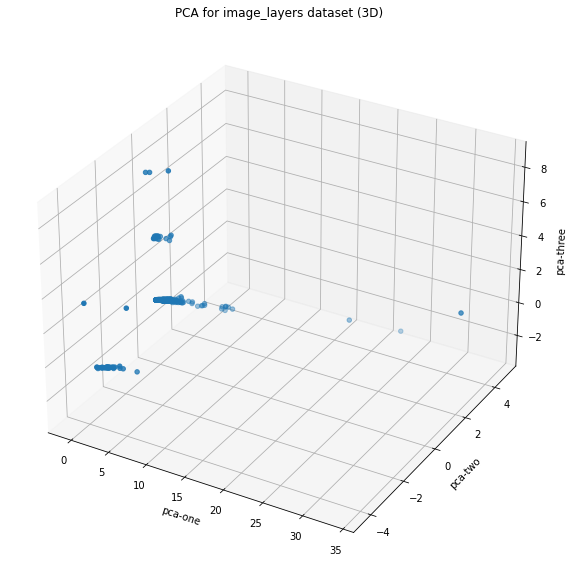

In [28]:
# Visualizing the results of the 3D PCA.
ax = plt.figure(figsize=(10, 10)).gca(projection="3d")
plt.title("3D Principal Component Analysis (PCA)")
ax.scatter(
    xs=pc3[:, 0],
    ys=pc3[:, 1],
    zs=pc3[:, 2],
)
ax.set_xlabel("pca-one")
ax.set_ylabel("pca-two")
ax.set_zlabel("pca-three")
plt.title("PCA for image_layers dataset (3D)")
plt.show()

**Interactive 3D plot for image layer dataset**

In [29]:
fig = px.scatter_3d(pc3, x=pc3[:, 0], y=pc3[:, 1], z=pc3[:, 2], opacity=1)
fig.update_traces(marker=dict(size=2))
fig.show()

**3D principal component analysis for container dataset**

In [30]:
pcc3 = pca3.fit_transform(X_cont)

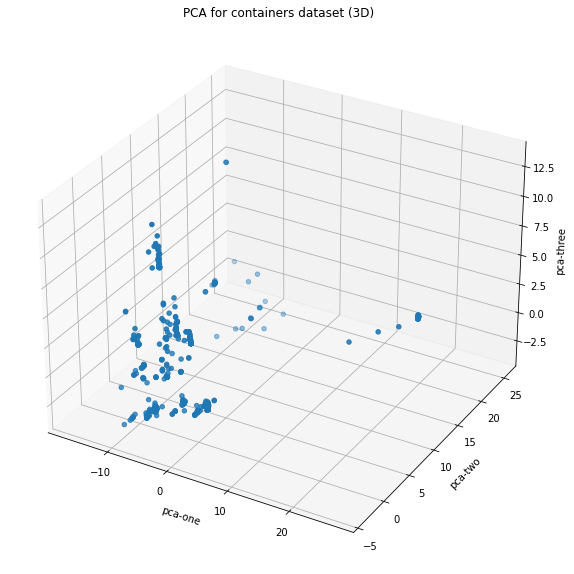

In [31]:
# Visualizing the results of the 3D PCA.
ax = plt.figure(figsize=(10, 10)).gca(projection="3d")
plt.title("3D Principal Component Analysis (PCA)")
ax.scatter(
    xs=pcc3[:, 0],
    ys=pcc3[:, 1],
    zs=pcc3[:, 2],
)
ax.set_xlabel("pca-one")
ax.set_ylabel("pca-two")
ax.set_zlabel("pca-three")
plt.title("PCA for containers dataset (3D)")
plt.show()

**3D interactive visualization**

In [32]:
fig = px.scatter_3d(pcc3, x=pcc3[:, 0], y=pcc3[:, 1], z=pcc3[:, 2], opacity=1)
fig.update_traces(marker=dict(size=2))
fig.show()

Now that we have visualized both image_layer dataset and container dataset in 3D. We now implement `Kmeans` to identify different clusters in the set.

Before applying KMeans by inserting the number of clusters, we first find the optimal number of clusters in the dataset by using the Elbow method.

## **The Elbow Method** 

The elbow method is used to determine the optimal numbers of clusters in K-means clustering. The elbow method plots the value of `inertia` produced by different values of K. 

Inertia is the within-cluster sum of squares criterion. It is a metric that shows how internally coherant the clusters are. It measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

Applying the elbow method for the image layer dataset, we set the range of cluster from 1 - 10. 

In [33]:
# How to find the best number of clusters?

no_of_clusters = range(1, 10)
inertia = []

for f in tqdm(no_of_clusters):
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X_image)
    u = kmeans.inertia_
    inertia.append(u)

100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


**Inertia vs Number of cluster plot**

Text(0.5, 1.0, 'Inertia plot per K')

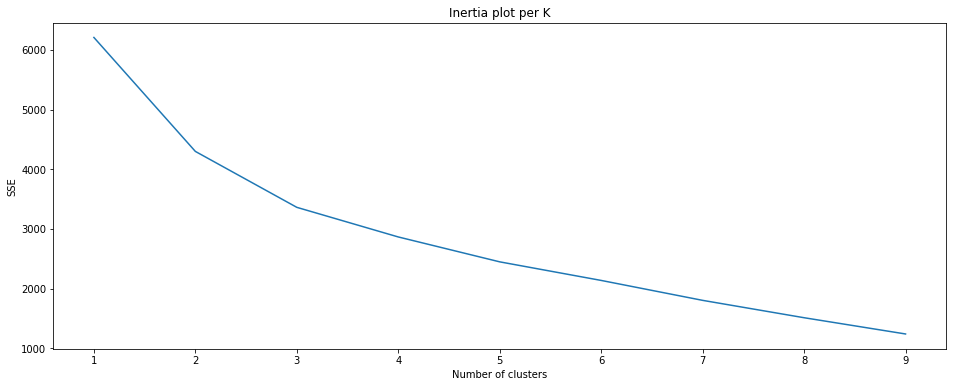

In [34]:
fig, (ax1) = plt.subplots(1, figsize=(16, 6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation="horizontal")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Inertia plot per K")

From the above plot, it is seen that the optimal number of clusters for image layers dataset is 3. We will later apply it when implementing KMeans algorithm.

Next, we search for optimal number of clusters for **container dataset**.

In [35]:
# How to find the best number of clusters?

no_of_clusters = range(1, 10)
inertia = []

for f in tqdm(no_of_clusters):
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X_cont)
    u = kmeans.inertia_
    inertia.append(u)

100%|██████████| 9/9 [00:18<00:00,  2.11s/it]


Text(0.5, 1.0, 'Inertia plot per K')

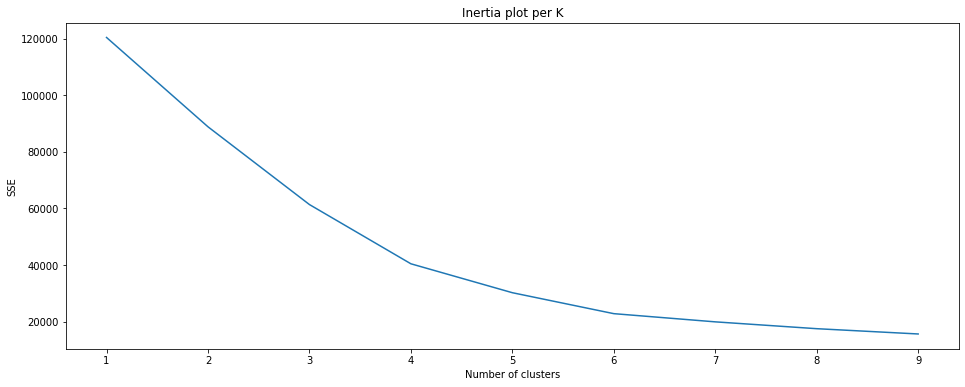

In [36]:
fig, (ax1) = plt.subplots(1, figsize=(16, 6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation="horizontal")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Inertia plot per K")

Based on the elbow plot, we will take 4 as the optimal number of clusters, which we will later apply through KMeans.

# Implementing KMeans for `image_layer_dataset`

We take the number of clusters = 3 and apply the KMeans algorithm.

In [37]:
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans = kmeans.fit(X_image)
clusters = kmeans.predict(X_image)

In [38]:
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [39]:
cluster_image_df = pd.concat([new_image1, new_image2], axis=1)
cluster_image_df["clusters"] = clusters

In [40]:
cluster_image_df.head()

3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   
003ba133-e754-4d5a-bc57-675b386d1f05                                  0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                                  0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   
003ba133-e754-4d5a-bc57-675b386d1f05                          0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                          0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
00351e6e-53ce-465e-9493-cf0cd2367049                         0   
003ba133-e754-4d5a-bc57-675b386d1f05                         0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                         0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                         0   

                                      3scale-amp2/zync-rhel7  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
00351e6e-53ce-465e-9493-cf0cd2367049                       0   
003ba133-e754-4d5a-bc57-675b386d1f05                       0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                       0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                       0   

                                      jboss-amq-6/amq63-openshift  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            0   

                                      openshift/ose-cli  \
cluster_id                                                
00003d61-9db1-4757-9cd1-84df271daeb9                  5   
00351e6e-53ce-465e-9493-cf0cd2367049                  5   
003ba133-e754-4d5a-bc57-675b386d1f05                  5   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                  5   
00748c32-15c3-4586-98fb-e5078ca9f3b8                  5   

                                      openshift/ose-cli-artifacts  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            6   
00351e6e-53ce-465e-9493-cf0cd2367049                            6   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            6   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            6   

                                      openshift/ose-grafana  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   
003ba133-e75

**Visualizing the results of the 3D PCA**

In [41]:
pca_i = pca3.fit_transform(cluster_image_df)

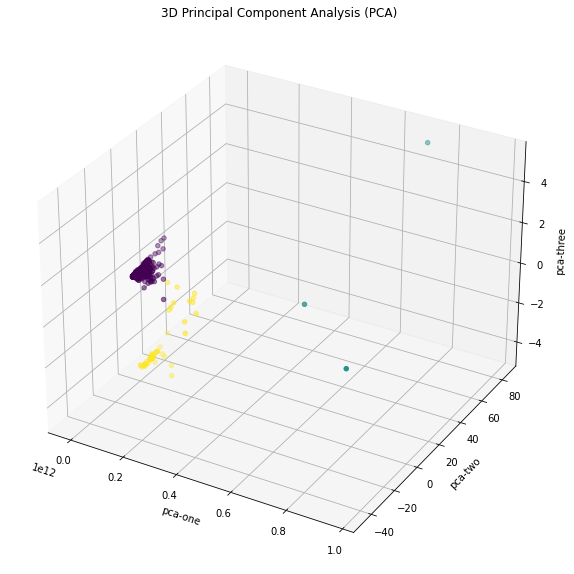

In [42]:
# Visualizing the results of the 3D PCA.
ax = plt.figure(figsize=(10, 10)).gca(projection="3d")
plt.title("3D Principal Component Analysis (PCA)")
ax.scatter(
    xs=pca_i[:, 0], ys=pca_i[:, 1], zs=pca_i[:, 2], c=cluster_image_df["clusters"]
)
ax.set_xlabel("pca-one")
ax.set_ylabel("pca-two")
ax.set_zlabel("pca-three")
plt.show()

**3D interactive visualization for image dataset**

In [43]:
fig = px.scatter_3d(
    pca_i,
    x=pca_i[:, 0],
    y=pca_i[:, 1],
    z=pca_i[:, 2],
    color=cluster_image_df["clusters"],
    opacity=1,
)
fig.update_traces(marker=dict(size=2))
fig.show()

**Listing out the groups of image_name in different clusters**

In [44]:
cluster_image_df[cluster_image_df.clusters == 0].head()

3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   
003ba133-e754-4d5a-bc57-675b386d1f05                                  0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                                  0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   
003ba133-e754-4d5a-bc57-675b386d1f05                          0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                          0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
00351e6e-53ce-465e-9493-cf0cd2367049                         0   
003ba133-e754-4d5a-bc57-675b386d1f05                         0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                         0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                         0   

                                      3scale-amp2/zync-rhel7  \
cluster_id                                                     
00003d61-9db1-4757-9cd1-84df271daeb9                       0   
00351e6e-53ce-465e-9493-cf0cd2367049                       0   
003ba133-e754-4d5a-bc57-675b386d1f05                       0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                       0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                       0   

                                      jboss-amq-6/amq63-openshift  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            0   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            0   

                                      openshift/ose-cli  \
cluster_id                                                
00003d61-9db1-4757-9cd1-84df271daeb9                  5   
00351e6e-53ce-465e-9493-cf0cd2367049                  5   
003ba133-e754-4d5a-bc57-675b386d1f05                  5   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                  5   
00748c32-15c3-4586-98fb-e5078ca9f3b8                  5   

                                      openshift/ose-cli-artifacts  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            6   
00351e6e-53ce-465e-9493-cf0cd2367049                            6   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            6   
00748c32-15c3-4586-98fb-e5078ca9f3b8                            6   

                                      openshift/ose-grafana  \
cluster_id                                                    
00003d61-9db1-4757-9cd1-84df271daeb9                      0   
00351e6e-53ce-465e-9493-cf0cd2367049                      0   
003ba133-e75

In [45]:
df1 = pd.DataFrame([])
global_mean = cluster_image_df.mean().sort_values(ascending=False)


for c in tqdm(range(0, 3)):
    c = cluster_image_df[cluster_image_df.clusters == c].iloc[:, :-3].mean()
    diff = c - global_mean
    d = diff.sort_values(ascending=False).head(20)
    d1 = pd.DataFrame(d).reset_index()
    d1.rename(columns={"index": "image_name"}, inplace=True)
    df1 = df1.append(d1.image_name)
df1 = df1.reset_index()
df1.rename(index={0: "cluster 1", 1: "cluster 2", 2: "cluster 3"}, inplace=True)
df1.drop(columns="index", inplace=True)

df1

100%|██████████| 3/3 [00:00<00:00, 198.42it/s]


0                  1  \
cluster 1       rhscl/mongodb-36-rhel7       ubi8/ruby-27   
cluster 2  openshift/ose-cli-artifacts  openshift/ose-cli   
cluster 3          rhel8/postgresql-12     rhel8/mysql-80   

                                   2                                  3  \
cluster 1             rhel8/httpd-24          rhscl/postgresql-10-rhel7   
cluster 2  openshift/ose-oauth-proxy  3scale-amp2/apicast-gateway-rhel8   
cluster 3      openshift/ose-jenkins          openshift/ose-must-gather   

                                     4                            5  \
cluster 1          openshift/ose-tests  jboss-amq-6/amq63-openshift   
cluster 2  3scale-amp2/memcached-rhel7          rhel8/postgresql-10   
cluster 3          openshift/ose-tools  openshift/ose-cli-artifacts   

                                   6                          7  \
cluster 1  3scale-amp2/backend-rhel7   3scale-amp2/system-rhel7   
cluster 2             ubi8/dotnet-50       rhscl/redis-32-rhel7   
cluster 3          openshift/ose-cli  openshift/ose-oauth-proxy   

                                           8                            9  \
cluster 1             3scale-amp2/zync-rhel7        openshift/ose-grafana   
cluster 2               rhscl/mysql-57-rhel7                rhel8/redis-5   
cluster 3  3scale-amp2/apicast-gateway-rhel8  3scale-amp2/memcached-rhel7   

                              10                        11  \
cluster 1    rhel8/postgresql-10            ubi8/dotnet-50   
cluster 2  openshift/ose-grafana  3scale-amp2/system-rhel7   
cluster 3   rhscl/mysql-57-rhel7            ubi8/dotnet-50   

                               12                           13  \
cluster 1    rhscl/redis-32-rhel7         rhscl/mysql-57-rhel7   
cluster 2  3scale-amp2/zync-rhel7  jboss-amq-6/amq63-openshift   
cluster 3     rhel8/postgresql-10                rhel8/redis-5   

                                  14                           15  \
cluster 1              rhel8/redis-5  3scale-amp2/memcached-rhel7   
cluster 2  3scale-amp2/backend-rhel7          openshift/ose-tests   
cluster 3       rhscl/redis-32-rhel7        openshift/ose-grafana   

                                          16                         17  \
cluster 1  3scale-amp2/apicast-gateway-rhel8  openshift/ose-oauth-proxy   
cluster 2                     rhel8/httpd-24  rhscl/postgresql-10-rhel7   
cluster 3        jboss-amq-6/amq63-openshift  3scale-amp2/backend-rhel7   

                               18                           19  
cluster 1       openshift/ose-cli  openshift/ose-cli-artifacts  
cluster 2            ubi8/ruby-27               rhel8/mysql-80  
cluster 3  3scale-amp2/zync-rhel7     3scale-amp2/system-rhel7

In [46]:
df = pd.DataFrame([])
for i in tqdm(range(0, 3)):
    c = cluster_image_df[cluster_image_df.clusters == i].iloc[:, -3:-1]
    v1 = c["value_cluster:cpu_usage_cores:sum"].mean()
    v2 = c["value_cluster:memory_usage_bytes:sum"].mean()
    df2 = pd.DataFrame(
        {
            "value_cluster:cpu_usage_cores:sum": [v1],
            "value_cluster:memory_usage_bytes:sum": [v2],
        }
    )
    df = df.append(df2)
df = df.reset_index()
df.rename(index={0: "cluster 1", 1: "cluster 2", 2: "cluster 3"}, inplace=True)
df.drop(columns="index", inplace=True)

100%|██████████| 3/3 [00:00<00:00, 765.80it/s]


In [47]:
new_df = pd.concat([df, df1], axis=1)
new_df

value_cluster:cpu_usage_cores:sum  \
cluster 1                           3.118776   
cluster 2                          82.482280   
cluster 3                          10.394131   

           value_cluster:memory_usage_bytes:sum                            0  \
cluster 1                          2.194704e+10       rhscl/mongodb-36-rhel7   
cluster 2                          8.133262e+11  openshift/ose-cli-artifacts   
cluster 3                          9.272735e+10          rhel8/postgresql-12   

                           1                          2  \
cluster 1       ubi8/ruby-27             rhel8/httpd-24   
cluster 2  openshift/ose-cli  openshift/ose-oauth-proxy   
cluster 3     rhel8/mysql-80      openshift/ose-jenkins   

                                           3                            4  \
cluster 1          rhscl/postgresql-10-rhel7          openshift/ose-tests   
cluster 2  3scale-amp2/apicast-gateway-rhel8  3scale-amp2/memcached-rhel7   
cluster 3          openshift/ose-must-gather          openshift/ose-tools   

                                     5                          6  \
cluster 1  jboss-amq-6/amq63-openshift  3scale-amp2/backend-rhel7   
cluster 2          rhel8/postgresql-10             ubi8/dotnet-50   
cluster 3  openshift/ose-cli-artifacts          openshift/ose-cli   

                                   7                                  8  \
cluster 1   3scale-amp2/system-rhel7             3scale-amp2/zync-rhel7   
cluster 2       rhscl/redis-32-rhel7               rhscl/mysql-57-rhel7   
cluster 3  openshift/ose-oauth-proxy  3scale-amp2/apicast-gateway-rhel8   

                                     9                     10  \
cluster 1        openshift/ose-grafana    rhel8/postgresql-10   
cluster 2                rhel8/redis-5  openshift/ose-grafana   
cluster 3  3scale-amp2/memcached-rhel7   rhscl/mysql-57-rhel7   

                                 11                      12  \
cluster 1            ubi8/dotnet-50    rhscl/redis-32-rhel7   
cluster 2  3scale-amp2/system-rhel7  3scale-amp2/zync-rhel7   
cluster 3            ubi8/dotnet-50     rhel8/postgresql-10   

                                    13                         14  \
cluster 1         rhscl/mysql-57-rhel7              rhel8/redis-5   
cluster 2  jboss-amq-6/amq63-openshift  3scale-amp2/backend-rhel7   
cluster 3                rhel8/redis-5       rhscl/redis-32-rhel7   

                                    15                                 16  \
cluster 1  3scale-amp2/memcached-rhel7  3scale-amp2/apicast-gateway-rhel8   
cluster 2          openshift/ose-tests                     rhel8/httpd-24   
cluster 3        openshift/ose-grafana        jboss-amq-6/amq63-openshift   

                                  17                      18  \
cluster 1  openshift/ose-oauth-proxy       openshift/ose-cli   
cluster 2  rhscl/postgresql-10-rhel7            ubi8/ruby-27   
cluster 3  3scale-amp2/backend-rhel7  3scale-amp2/zync-rhel7   

                                    19  
cluster 1  openshift/ose-cli-artifacts  
cluster 2               rhel8/mysql-80  
cluster 3     3scale-amp2/system-rhel7

There are three clusters for the image layer datasets. In the above dataframe, we tried to group the image repos name on the basis of the difference between global and individual cluster mean. Also, we calculated the mean value of the corresponding telemetry data for the particular cluster. 

The first group, i.e, `cluster 1`, represents the group of image_repos having the higher chances of occuring in same cluster_id and corresponding `cpu_usage` of 3.11 cores and `momory`, 21 GB. The second group consists of the group of image_repos having the higher probability of occuring in same cluster_id with `cpu_usage` 82.4 cores and `memory`, 813 GB. Similarly, the third group has the values for `cpu_usage` as 10.39 cores and `memory`, 92 GB. 

# Implementing KMeans for `container dataset`

We take the number of clusters = 4. Because of the large number of unique features, the program will be computationally intensive. We apply KMeans algorithm by selecting 10 clusters.

In [48]:
kmeans = KMeans(n_clusters=4, random_state=2)
kmeans = kmeans.fit(X_cont)
clusters = kmeans.predict(X_cont)

In [49]:
clusters

array([1, 2, 1, ..., 1, 1, 0], dtype=int32)

In [50]:
cluster_cont_df = pd.concat([new_cont1, new_cont2], axis=1)
cluster_cont_df["clusters"] = clusters

In [51]:
cluster_cont_df.head()

3scale-amp2/3scale-rhel7-operator  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   
003ba133-e754-4d5a-bc57-675b386d1f05                                  0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                                  0   

                                      3scale-amp2/apicast-gateway-rhel8  \
cluster_id                                                                
00003d61-9db1-4757-9cd1-84df271daeb9                                  0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                  0   
00351e6e-53ce-465e-9493-cf0cd2367049                                  0   
003ba133-e754-4d5a-bc57-675b386d1f05                                  0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                                  0   

                                      3scale-amp2/backend-rhel7  \
cluster_id                                                        
00003d61-9db1-4757-9cd1-84df271daeb9                          0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                          0   
00351e6e-53ce-465e-9493-cf0cd2367049                          0   
003ba133-e754-4d5a-bc57-675b386d1f05                          0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                          0   

                                      3scale-amp2/memcached-rhel7  \
cluster_id                                                          
00003d61-9db1-4757-9cd1-84df271daeb9                            0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                            0   
00351e6e-53ce-465e-9493-cf0cd2367049                            0   
003ba133-e754-4d5a-bc57-675b386d1f05                            0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                            0   

                                      3scale-amp2/system-rhel7  \
cluster_id                                                       
00003d61-9db1-4757-9cd1-84df271daeb9                         0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                         0   
00351e6e-53ce-465e-9493-cf0cd2367049                         0   
003ba133-e754-4d5a-bc57-675b386d1f05                         0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                         0   

                                      3scale-amp2/zync-rhel7  Calico Operator  \
cluster_id                                                                      
00003d61-9db1-4757-9cd1-84df271daeb9                       0                0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                       0                0   
00351e6e-53ce-465e-9493-cf0cd2367049                       0                0   
003ba133-e754-4d5a-bc57-675b386d1f05                       0                0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                       0                0   

                                      Cilium  \
cluster_id                                     
00003d61-9db1-4757-9cd1-84df271daeb9       0   
002663ad-bcf4-4c7c-9530-ecb351fe4001       0   
00351e6e-53ce-465e-9493-cf0cd2367049       0   
003ba133-e754-4d5a-bc57-675b386d1f05       0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c       0   

                                      Cloud Native PostgreSQL Operator  \
cluster_id                                                               
00003d61-9db1-4757-9cd1-84df271daeb9                                 0   
002663ad-bcf4-4c7c-9530-ecb351fe4001                                 0   
00351e6e-53ce-465e-9493-cf0cd2367049                                 0   
003ba133-e754-4d5a-bc57-675b386d1f05                                 0   
00479ead-b7fc-49c2-ae20-3990a9b3d08c                                 0   

                                      Elastic Cloud on Kubernetes  \
cluster_id                                                          
00003d6

**Visualizing the results of the 3D PCA**

In [52]:
pca_c = pca3.fit_transform(cluster_cont_df)

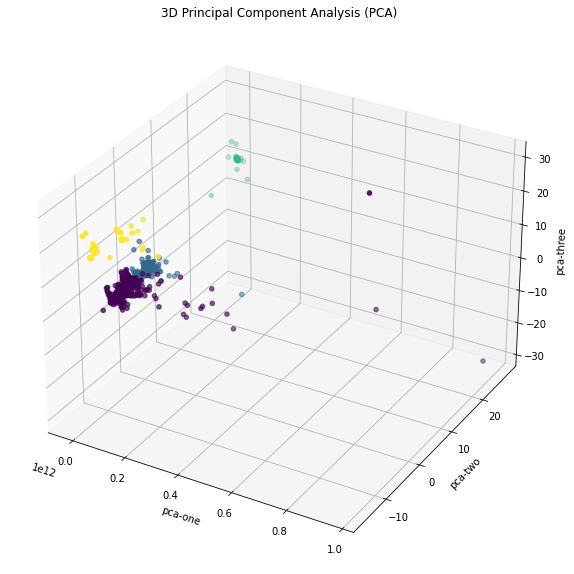

In [53]:
# Visualizing the results of the 3D PCA.
ax = plt.figure(figsize=(10, 10)).gca(projection="3d")
plt.title("3D Principal Component Analysis (PCA)")
ax.scatter(
    xs=pca_c[:, 0], ys=pca_c[:, 1], zs=pca_c[:, 2], c=cluster_cont_df["clusters"]
)
ax.set_xlabel("pca-one")
ax.set_ylabel("pca-two")
ax.set_zlabel("pca-three")
plt.show()

**3D interactive visualization for image dataset**

In [54]:
fig = px.scatter_3d(
    pca_c,
    x=pca_c[:, 0],
    y=pca_c[:, 1],
    z=pca_c[:, 2],
    color=cluster_cont_df["clusters"],
    opacity=1,
)
fig.update_traces(marker=dict(size=2))
fig.show()

**Listing out the groups of image_name in different clusters**

In [55]:
df1 = pd.DataFrame([])
global_mean = cluster_cont_df.mean().sort_values(ascending=False)


for c in tqdm(range(0, 4)):
    c = cluster_cont_df[cluster_cont_df.clusters == c].iloc[:, :-3].mean()
    diff = c - global_mean
    d = diff.sort_values(ascending=False).head(20)
    d1 = pd.DataFrame(d).reset_index()
    d1.rename(columns={"index": "image_name"}, inplace=True)
    df1 = df1.append(d1.image_name)
df1 = df1.reset_index()
df1.rename(
    index={0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4"}, inplace=True
)
df1.drop(columns="index", inplace=True)

df1

100%|██████████| 4/4 [00:00<00:00, 167.04it/s]


0  \
cluster 1         openshift/ose-kube-rbac-proxy   
cluster 2                     rhacm2/work-rhel8   
cluster 3  openshift/ose-local-storage-operator   
cluster 4                                rhceph   

                                               1  \
cluster 1     openshift/ose-machine-api-operator   
cluster 2              rhacm2/registration-rhel8   
cluster 3  openshift/ose-local-storage-diskmaker   
cluster 4          openshift/ose-kube-rbac-proxy   

                                                     2  \
cluster 1           openshift/ose-baremetal-runtimecfg   
cluster 2           rhacm2/registration-rhel8-operator   
cluster 3  openshift/ose-local-storage-operator-bundle   
cluster 4           openshift/ose-baremetal-runtimecfg   

                                                           3  \
cluster 1                               openshift/ose-ironic   
cluster 2                    rhacm2/multicloud-manager-rhel8   
cluster 3  container-native-virtualization/kubevirt-cpu-n...   
cluster 4             openshift/ose-csi-external-snapshotter   

                                                       4  \
cluster 1                   openshift/ose-ovn-kubernetes   
cluster 2  openshift/ose-cluster-kube-apiserver-operator   
cluster 3  container-native-virtualization/virt-operator   
cluster 4        openshift/ose-csi-node-driver-registrar   

                                                      5  \
cluster 1               openshift/ose-csi-livenessprobe   
cluster 2                          openshift/ose-thanos   
cluster 3  container-native-virtualization/virt-handler   
cluster 4            openshift/ose-machine-api-operator   

                                                         6  \
cluster 1                                openshift/ose-cli   
cluster 2                          openshift/ose-hyperkube   
cluster 3  container-native-virtualization/virt-controller   
cluster 4                  openshift/ose-csi-driver-manila   

                                                           7  \
cluster 1                   openshift/ose-aws-ebs-csi-driver   
cluster 2                                 openshift/ose-etcd   
cluster 3  container-native-virtualization/kubernetes-nms...   
cluster 4                       openshift/ose-csi-driver-nfs   

                                                     8  \
cluster 1       openshift/ose-csi-external-provisioner   
cluster 2                    openshift/ose-oauth-proxy   
cluster 3  container-native-virtualization/kubemacpool   
cluster 4    openshift/ose-openstack-cinder-csi-driver   

                                                           9  \
cluster 1                     openshift/ose-ironic-inspector   
cluster 2                                  openshift/ose-sdn   
cluster 3  container-native-virtualization/node-maintenan...   
cluster 4             openshift/ose-csi-external-provisioner   

                                              10  \
cluster 1    openshift/ose-ironic-ipa-downloader   
cluster 2  openshift/ose-machine-config-operator   
cluster 3                         ubi8/dotnet-50   
cluster 4                              rook-ceph   

                                                   11  \
cluster 1  openshift/ose-ironic-machine-os-downloader   
cluster 2      openshift/ose-cluster-network-operator   
cluster 3                                      Cilium   
cluster 4                         rhel8/postgresql-12   

                                                   12  \
cluster 1     openshift/ose-csi-node-driver-registrar   
cluster 2              openshift/ose-prom-label-proxy   
cluster 3  openshift-serverless-1/serving-queue-rhel8   
cluster 4       openshift/ose-local-storage-diskmaker   

                                                          13  \
cluster 1                openshift/ose-csi-external-attacher   
cluster 2  openshift/ose-cluster-kube-controller-manager-...   
cluster 3  container-native-virtualization/cnv-cont

In [56]:
df = pd.DataFrame([])
for i in tqdm(range(0, 4)):
    c = cluster_cont_df[cluster_cont_df.clusters == i].iloc[:, -3:-1]
    v1 = c["value_cluster:cpu_usage_cores:sum"].mean()
    v2 = c["value_cluster:memory_usage_bytes:sum"].mean()
    df2 = pd.DataFrame(
        {
            "value_cluster:cpu_usage_cores:sum": [v1],
            "value_cluster:memory_usage_bytes:sum": [v2],
        }
    )
    df = df.append(df2)
df = df.reset_index()
df.rename(
    index={0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4"}, inplace=True
)
df.drop(columns="index", inplace=True)

100%|██████████| 4/4 [00:00<00:00, 503.22it/s]


In [57]:
new_df = pd.concat([df, df1], axis=1)
new_df

value_cluster:cpu_usage_cores:sum  \
cluster 1                           6.023516   
cluster 2                           2.331292   
cluster 3                           6.023818   
cluster 4                           9.784137   

           value_cluster:memory_usage_bytes:sum  \
cluster 1                          4.486924e+10   
cluster 2                          1.732900e+10   
cluster 3                          2.880826e+10   
cluster 4                          6.328147e+10   

                                              0  \
cluster 1         openshift/ose-kube-rbac-proxy   
cluster 2                     rhacm2/work-rhel8   
cluster 3  openshift/ose-local-storage-operator   
cluster 4                                rhceph   

                                               1  \
cluster 1     openshift/ose-machine-api-operator   
cluster 2              rhacm2/registration-rhel8   
cluster 3  openshift/ose-local-storage-diskmaker   
cluster 4          openshift/ose-kube-rbac-proxy   

                                                     2  \
cluster 1           openshift/ose-baremetal-runtimecfg   
cluster 2           rhacm2/registration-rhel8-operator   
cluster 3  openshift/ose-local-storage-operator-bundle   
cluster 4           openshift/ose-baremetal-runtimecfg   

                                                           3  \
cluster 1                               openshift/ose-ironic   
cluster 2                    rhacm2/multicloud-manager-rhel8   
cluster 3  container-native-virtualization/kubevirt-cpu-n...   
cluster 4             openshift/ose-csi-external-snapshotter   

                                                       4  \
cluster 1                   openshift/ose-ovn-kubernetes   
cluster 2  openshift/ose-cluster-kube-apiserver-operator   
cluster 3  container-native-virtualization/virt-operator   
cluster 4        openshift/ose-csi-node-driver-registrar   

                                                      5  \
cluster 1               openshift/ose-csi-livenessprobe   
cluster 2                          openshift/ose-thanos   
cluster 3  container-native-virtualization/virt-handler   
cluster 4            openshift/ose-machine-api-operator   

                                                         6  \
cluster 1                                openshift/ose-cli   
cluster 2                          openshift/ose-hyperkube   
cluster 3  container-native-virtualization/virt-controller   
cluster 4                  openshift/ose-csi-driver-manila   

                                                           7  \
cluster 1                   openshift/ose-aws-ebs-csi-driver   
cluster 2                                 openshift/ose-etcd   
cluster 3  container-native-virtualization/kubernetes-nms...   
cluster 4                       openshift/ose-csi-driver-nfs   

                                                     8  \
cluster 1       openshift/ose-csi-external-provisioner   
cluster 2                    openshift/ose-oauth-proxy   
cluster 3  container-native-virtualization/kubemacpool   
cluster 4    openshift/ose-openstack-cinder-csi-driver   

                                                           9  \
cluster 1                     openshift/ose-ironic-inspector   
cluster 2                                  openshift/ose-sdn   
cluster 3  container-native-virtualization/node-maintenan...   
cluster 4             openshift/ose-csi-external-provisioner   

                                              10  \
cluster 1    openshift/ose-ironic-ipa-downloader   
cluster 2  openshift/ose-machine-config-operator   
cluster 3                         ubi8/dotnet-50   
cluster 4                              rook-ceph   

                                                   11  \
cluster 1  openshift/ose-ironic-machine-os-downloader   
cluster 2      openshift/ose-cluster-network-operator   
cluster 3                                      Cilium   
cluster 4                         rhel8/postgresql-12  

There are four clusters for the containers datasets. In the above dataframe, we tried to group the image repos name on the basis of the difference between global and individual cluster mean. Also, we calculated the mean value of the corresponding telemetry data for the particular cluster. 

The first group, i.e, `cluster 1`, represents the group of image_repos having the higher chances of occuring in same cluster_id and corresponding `cpu_usage` of 6.02 cores and `momory`, 44 GB. The second group consists of the group of image_repos having the higher probability of occuring in same cluster_id with `cpu_usage` 2.3 cores and `memory`, 17 GB. Similarly, the third group has the values for `cpu_usage` as 6.02 cores and `memory`, 28 GB. The third group has the values for `cpu_usage` as 9.78 cores and `memory`, 63 GB.

# Conclusions

In this notebook, we employed KMeans ML clustering technique in order to group together image repos and their corresponding mean telemetry values per cluster. We begin with two datasets (image layer dataset, containers dataset) containing cluster_id, corresponding image_repos and telemetry data (i.e. cpu_cores and memory_bytes). The telemetry values were extracted with respect to the cluster_id, which mean for the given cluster_id containing two different image repos, we have the same telemetry value. We then employed One hot encoding technique for categorical image repos name and grouped them with respect to its frequency in a cluster_id. The analysis is then followed by finding the optimal number of clusters by the use of Elbow method and then employing KMeans algorithm for the one hot encoded data. 

The results is that we got 3 groups of image repos with corresponding mean telemetry data for image layer dataset. And group of 4 for corresponding containers dataset. Each cluster group shows the image repos name which have the high probability of occuring in the same cluster_id and their corresponding mean telemetry values.